In [204]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import re
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import ttest_ind, sem
import matplotlib.dates
import climapy.climapy.climapy_stats as clps
from math import sqrt

In [317]:
#load model output files
# s1raw=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run2d_2000_d02.nc')
# s2raw=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run2d_eas0c_d02.nc')
s1a=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01.nc')
s1b=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02_d01.nc')
s1c=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_03_d01.nc')
s2a=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d01.nc')
s2b=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_02_d01.nc')
s2c=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_03_d01.nc')
time_a=pd.date_range('2000-01-01', periods=1825)
time_b=pd.date_range('2005-01-01', periods=1825)
time_c=pd.date_range('2010-01-01', periods=1825)
s1a['time']=time_a
s1b['time']=time_b
s1c['time']=time_c
s2a['time']=time_a
s2b['time']=time_b
s2c['time']=time_c
s1raw=xr.concat([s1a,s1b,s1c],dim='time')
s2raw=xr.concat([s2a,s2b,s2c],dim='time')
#slice to d02 domain. comment to use whole domain
latmin=6.74
latmax=20.40
lonmin=95.74
lonmax=110.08
# s1raw=s1raw.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
# s2raw=s2raw.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
# s1raw['PPT']=s1raw['PPT']
# s1raw['RAINNC']=s1raw['RAINNC']
# s2raw['PPT']=s2raw['PPT']
# s2raw['RAINNC']=s2raw['RAINNC']
print(np.mean(s1raw),np.mean(s2raw))
#load geography files
geo02=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/geo_em.d01.nc')

<xarray.Dataset>
Dimensions:   ()
Data variables:
    PPT       float64 12.94
    RAINNC    float64 2.031
    LANDMASK  float64 0.3184
    U10       float64 -1.057
    V10       float64 0.2941
    T2        float64 298.3
    SWDOWN    float64 185.7 <xarray.Dataset>
Dimensions:   ()
Data variables:
    PPT       float64 13.65
    RAINNC    float64 2.156
    LANDMASK  float64 0.3184
    U10       float64 -0.7117
    V10       float64 0.4829
    T2        float64 298.6
    SWDOWN    float64 182.2


(180, 89, 170)


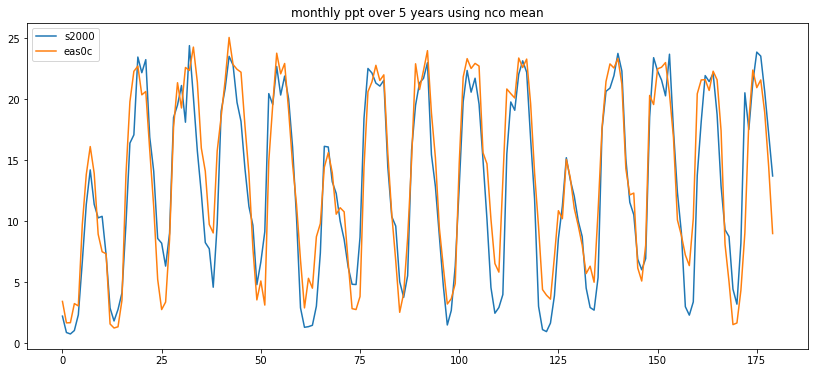

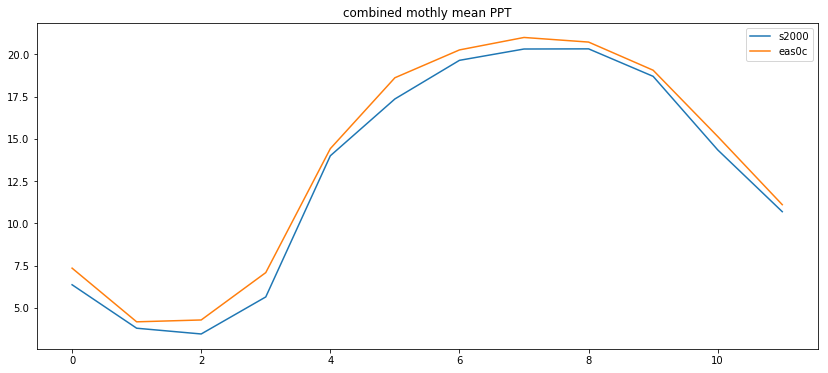

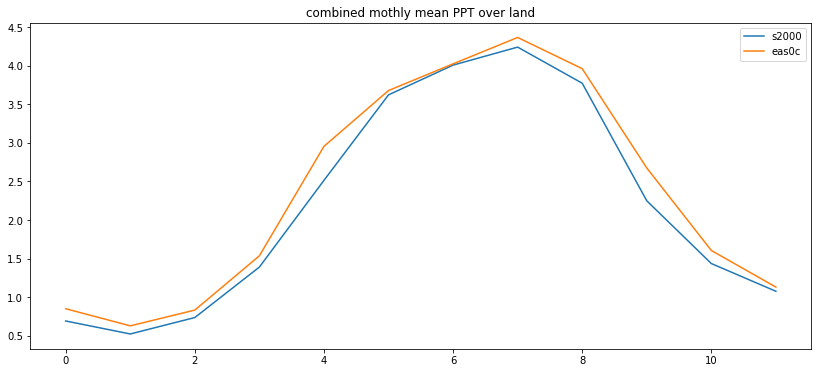

In [318]:
# resample to monthly ppt
plt.rcParams["figure.figsize"] = 14,6

#cut to last 3 years
s1rawa=s1raw#.sel(time=slice('2052-01-01', '2055-01-01'))
s2rawa=s2raw#.sel(time=slice('2052-01-01', '2055-01-01'))

def resampleWind(data):
    return data.U10.resample('1M',dim='time',how='mean'), data.V10.resample('1M',dim='time',how='mean')
s1_mth=s1rawa.PPT.resample('1M',dim='time',how='mean')
s2_mth=s2rawa.PPT.resample('1M',dim='time',how='mean')
s1_mth_cl=s1rawa.RAINNC.resample('1M',dim='time',how='mean')
s2_mth_cl=s2rawa.RAINNC.resample('1M',dim='time',how='mean')
s1U10,s1V10=resampleWind(s1raw)
s2U10,s2V10=resampleWind(s2raw)

landmsk=s1raw.LANDMASK.data
plt.figure(1)
plt.plot(np.mean(s1_mth,axis=(1,2)),label='s2000')
plt.plot(np.mean(s2_mth,axis=(1,2)),label='eas0c')
plt.title('monthly ppt over 5 years using nco mean')
plt.legend()
print(np.shape(s1_mth))
#aggregate into 12 monthly means
s1=s1_mth.groupby('time.month').mean(axis=0)
s2=s2_mth.groupby('time.month').mean(axis=0)
s1_cl=s1_mth_cl.groupby('time.month').mean(axis=0)
s2_cl=s2_mth_cl.groupby('time.month').mean(axis=0)
s1_u10=s1U10.groupby('time.month').mean(axis=0)
s1_v10=s1V10.groupby('time.month').mean(axis=0)
s2_u10=s2U10.groupby('time.month').mean(axis=0)
s2_v10=s2V10.groupby('time.month').mean(axis=0)
plt.figure(2)
plt.plot(np.mean(s1,axis=(1,2)),label='s2000')
plt.plot(np.mean(s2,axis=(1,2)),label='eas0c')
plt.title('combined mothly mean PPT')
plt.legend()
plt.figure(3)
plt.plot(np.mean(s1*landmsk[:12,:,:],axis=(1,2)),label='s2000')
plt.plot(np.mean(s2*landmsk[:12,:,:],axis=(1,2)),label='eas0c')
plt.title('combined mothly mean PPT over land')
plt.legend()
plt.show()

In [224]:
#data overview
print('year, s2000, eas0c, diff, %')
# print('50-54: {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1a.PPT.data),np.mean(s2a.PPT.data),\
#                                            (np.mean(s2a.PPT.data)-np.mean(s1a.PPT.data))/np.mean(s1a.PPT.data)*100))
# print('69-73: {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1b.PPT.data),np.mean(s2b.PPT.data),\
#                                            (np.mean(s2b.PPT.data)-np.mean(s1b.PPT.data))/np.mean(s1b.PPT.data)*100))
# print('90-94: {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1c.PPT.data),np.mean(s2c.PPT.data),\
#                                            (np.mean(s2c.PPT.data)-np.mean(s1c.PPT.data))/np.mean(s1c.PPT.data)*100))
print('mean: {:.4f} {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1.data),np.mean(s2.data),np.mean(s1.data)-np.mean(s2.data),(np.mean(s1.data)-np.mean(s2.data))/np.mean(s1.data)*100))
landmsk=s1raw.LANDMASK.data
landmsk[landmsk == 0] = np.nan

print('mean over land {:.4f} {:.4f} {:.2f}%'.format(np.nanmean(s1*landmsk[:12,:,:].data),np.nanmean(s2*landmsk[:12,:,:].data),\
                                                       (np.nanmean(s1*landmsk[:12,:,:].data)-np.nanmean(s2*landmsk[:12,:,:].data))/np.nanmean(s1*landmsk[:12,:,:].data)*100))

year, s2000, eas0c, diff, %
mean: 12.8877 13.6026 -0.7149 -5.55%
mean over land 6.8717 7.3906 -7.55%


#### data from individual runs
year, s2000, eas0c, diff % 
50-54: 9.4236 10.3650 9.99% 
69-73: 9.3686 10.7211 14.44% 
90-94: 9.5697 10.3455 8.11% 
mean: 9.4059 10.4337 10.93% 
mean over land 7.1474 7.7201 8.01%
##### Last 3 years
mean: 10.1881 11.1170 9.12%
mean over land 7.7872 8.3445 7.16%


### Quarterly spatial plot ###

In [214]:
#resampling wind and ppt to quarterly
def qtr_sam(data):
    time,lat,lon=np.shape(data)
    myperm=list(range(2,180))
    myperm.append(0)
    myperm.append(1)
    qtr_raw=np.reshape(data.data[myperm,:,:],(-1,3,lat,lon))
    return np.mean(qtr_raw,axis=1)

def agg_qtr(data):
    qtr_raw=qtr_sam(data)
    ti,lat,lon=np.shape(qtr_raw)
    qtr_shaped=np.reshape(qtr_raw.data,(-1,4,lat,lon))
    return np.mean(qtr_shaped,axis=(0)),qtr_shaped

def new_msk(s1,s2):
    t1,p1 = ttest_ind(s2,s1)
    lim1 = clps.stats_fdr(p1,0.1)
    pp1 = np.ma.masked_greater(p1, lim1)
    return pp1

    

(4, 89, 170) (15, 4, 89, 170)


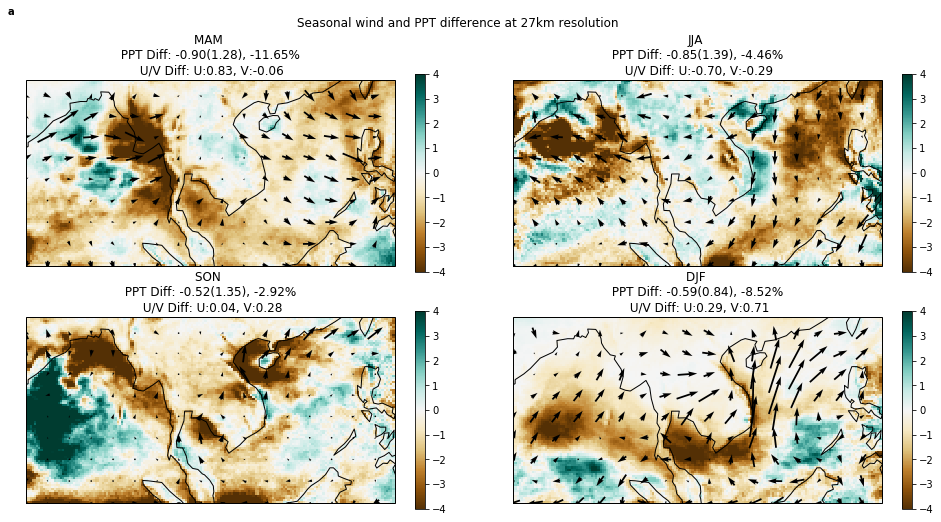

In [319]:
s1_qtr,s1_qtr_shaped=agg_qtr(s1_mth)
s2_qtr,s2_qtr_shaped=agg_qtr(s2_mth)
print(np.shape(s1_qtr),np.shape(s1_qtr_shaped))
s1U10_qtr=agg_qtr(s1U10)
s1V10_qtr=agg_qtr(s1V10)
s2U10_qtr=agg_qtr(s2U10)
s2V10_qtr=agg_qtr(s2V10)
pptdiff=s1_qtr-s2_qtr
udiff=s1U10[:,::10,::10]-s2U10[:,::10,::10]
vdiff=s1V10[:,::10,::10]-s2V10[:,::10,::10]

quarters={1:'MAM',2:'JJA',3:'SON',4:'DJF'}

plt.rcParams["figure.figsize"] = 16,8#16,8,8    
slon1 = s1raw.lon[0::10]
slat1 = s1raw.lat[0::10]
cmap = plt.get_cmap('BrBG')
vminn=-4
vmaxx=4
scale=50
sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=vminn, vmax=vmaxx))
sm._A = []
def draw_title(tt):
    return str('{} \n PPT Diff: {:.2f}({:.2f}), {:.2f}% \n U/V Diff: U:{:.2f}, V:{:.2f}'.format(quarters[tt+1],np.nanmean(pptdiff[tt,:,:]),\
            (((sem(np.mean(s1_qtr_shaped,axis=(2,3))))**2+(sem(np.mean(s2_qtr_shaped,axis=(2,3))))**2)**0.5)[tt], (np.nanmean(pptdiff[tt,:,:])/np.nanmean(s1_qtr[tt,:,:])*100), \
            float(np.mean(udiff[tt,:,:])),float(np.mean(vdiff[tt,:,:])) ))
def draw_qtr_plt(ax,tt):
    ax.pcolormesh(s1raw.lon, s1raw.lat,pptdiff[tt,:,:],vmin=vminn,vmax=vmaxx,cmap=cmap)
    ax.pcolor(s1raw.lon, s1raw.lat, new_msk(s1_qtr_shaped[:,tt,:,:],s2_qtr_shaped[:,tt,:,:]), hatch='/', alpha=0.)
    ax.quiver(slon1,slat1,udiff[tt,:,:],vdiff[tt,:,:],pivot='middle',scale=scale)
    ax.coastlines()
    plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05)
    ax.set_title(draw_title(tt))
    

ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
draw_qtr_plt(ax1,0)
ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
draw_qtr_plt(ax2,1)
ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
draw_qtr_plt(ax3,2)
ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
draw_qtr_plt(ax4,3)
plt.suptitle('Seasonal wind and PPT difference at 27km resolution')
ax1.text(-0.05, 1.35, 'a', transform=ax1.transAxes, 
            size=10, weight='bold')
plt.show()

In [203]:
# (((sem(np.mean(s1_qtr_shaped,axis=(2,3))))**2+(sem(np.mean(s2_qtr_shaped,axis=(2,3))))**2)**0.5)[0]
print(sem(np.mean(s1_qtr_shaped,axis=(2,3))))
print(((sem(np.mean(s1_qtr_shaped,axis=(2,3))))**2)**0.5)

[ 0.92661825  1.00219798  0.90265854  0.51957046]
[ 0.92661825  1.00219798  0.90265854  0.51957046]


Month is 1 Mean diff over land: -0.4988, -23.01%


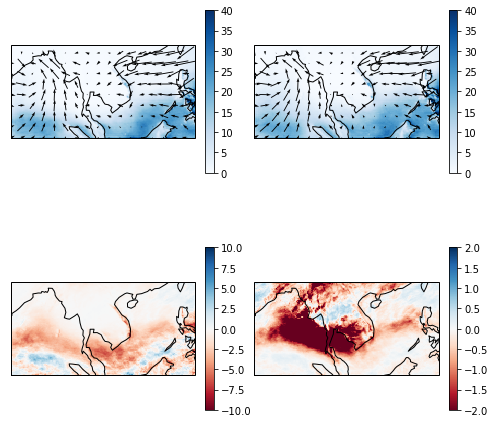

Month is 2 Mean diff over land: -0.3306, -20.18%


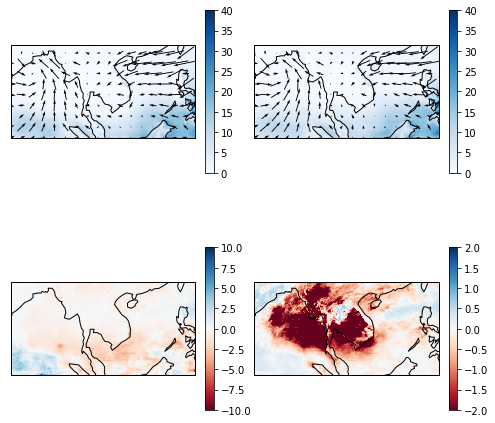

Month is 3 Mean diff over land: -0.3035, -13.15%


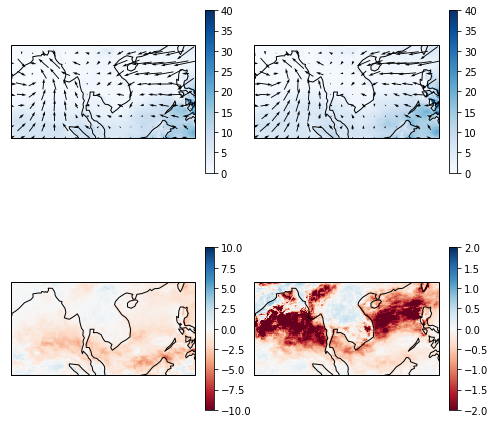

Month is 4 Mean diff over land: -0.4585, -10.51%


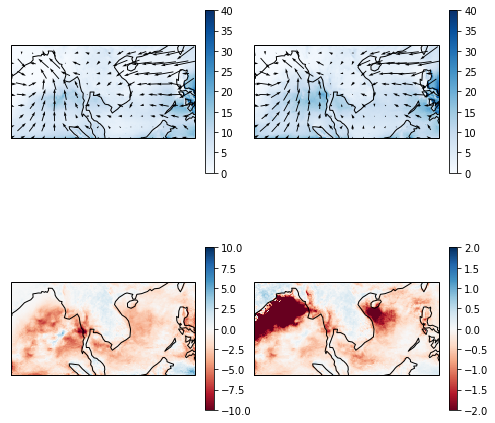

Month is 5 Mean diff over land: -1.3853, -17.55%


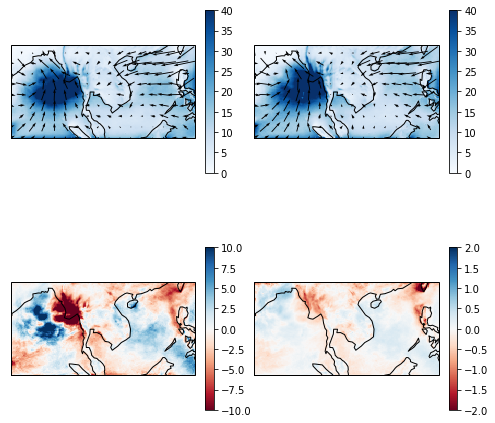

Month is 6 Mean diff over land: -0.1750, -1.54%


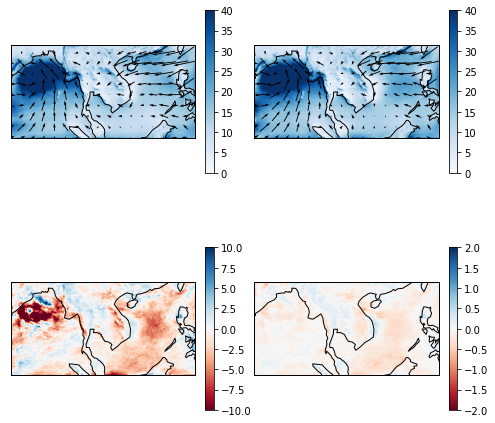

Month is 7 Mean diff over land: -0.0518, -0.41%


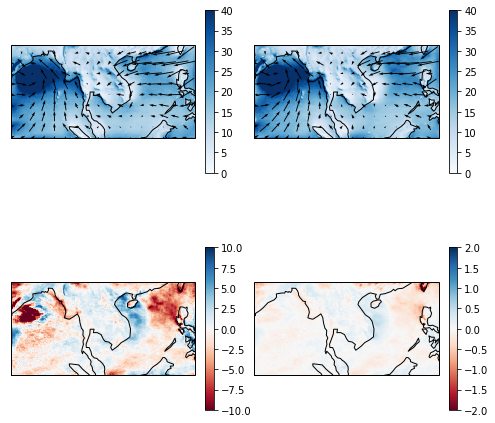

Month is 8 Mean diff over land: -0.3930, -2.95%


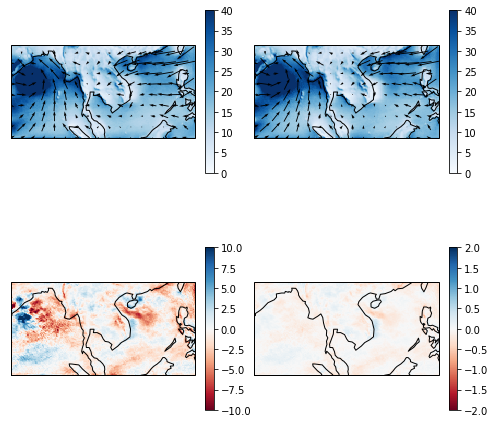

Month is 9 Mean diff over land: -0.5918, -4.99%


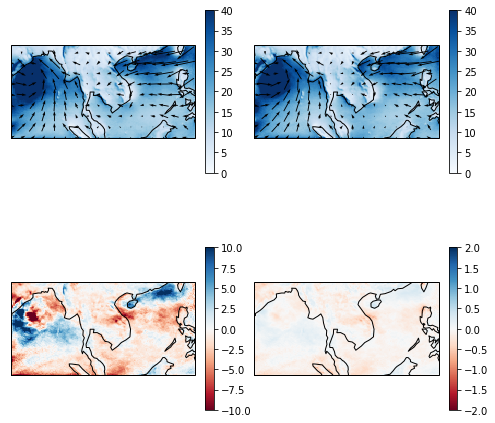

Month is 10 Mean diff over land: -1.3363, -18.92%


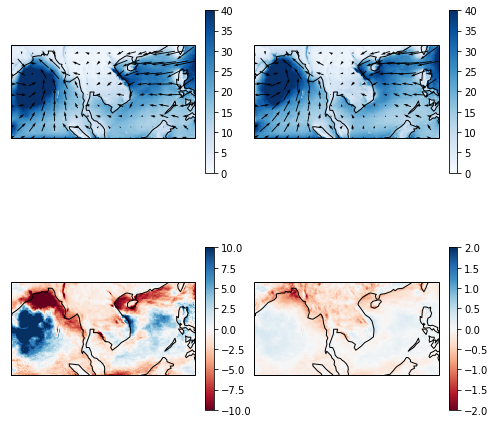

Month is 11 Mean diff over land: -0.5318, -11.80%


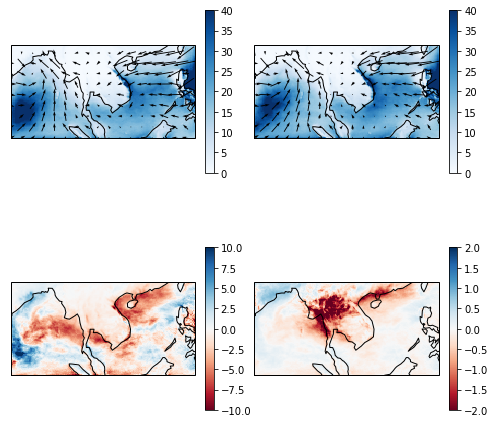

Month is 12 Mean diff over land: -0.1706, -5.05%


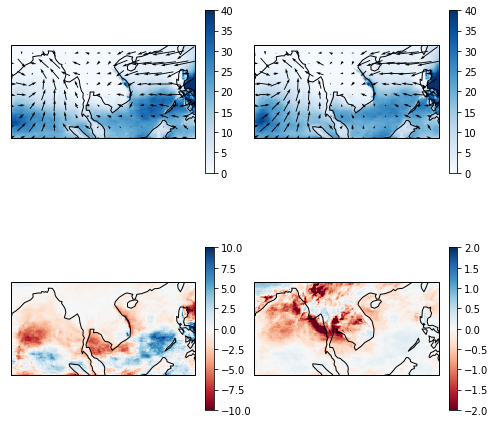

In [147]:
landmsk=s1raw.LANDMASK.data
plt.rcParams["figure.figsize"] = 8,8
base=s1.data
base[base == 0]=np.nan
diffabs=[]
diffratio=[]
for tt in range(0,12):
    plt.figure(tt)
    uwind1=np.mean(s1_u10[:,::10,::10],axis=0)
    vwind1=np.mean(s1_v10[:,::10,::10],axis=0)
    slon1 = s1raw.lon[0::10]
    slat1 = s1raw.lat[0::10]
    uwind2=np.mean(s2_u10[:,::10,::10],axis=0)
    vwind2=np.mean(s2_v10[:,::10,::10],axis=0)
    slon2 = s2raw.lon[0::10]
    slat2 = s2raw.lat[0::10]
    ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
    ax1.pcolor(s1raw.lon, s1raw.lat,s1[tt,:,:],vmin=0,vmax=40,cmap='Blues')
    ax1.quiver(slon1,slat1,uwind1,vwind1,pivot='middle')
    ax1.coastlines()
    ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
    ax2.pcolor(s1raw.lon,s1raw.lat,s2[tt,:,:],vmin=0,vmax=40,cmap='Blues')
    ax2.quiver(slon2,slat2,uwind2,vwind2,pivot='middle')
    ax2.coastlines()
    cmap = plt.get_cmap('Blues')
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=0, vmax=40))
    sm._A = []
    plt.colorbar(sm,ax=ax2,fraction=0.04, pad=0.05)
    plt.colorbar(sm,ax=ax1,fraction=0.04, pad=0.05)
    ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
    ax3.pcolor(s1raw.lon,s1raw.lat,s1[tt,:,:]-s2[tt,:,:],vmax=10,vmin=-10,cmap='RdBu')
    ax3.coastlines()
    cmap = plt.get_cmap('RdBu')
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=-10, vmax=10))
    sm._A = []
    plt.colorbar(sm,ax=ax3,fraction=0.04, pad=0.05)
    ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
    ratiomap=(s1[tt,:,:]-s2[tt,:,:])/(base[tt,:,:])
#     m = np.ma.masked_where(np.isnan(ratiomap),ratiomap)
#     m=np.ma.masked_invalid(ratiomap)
    cmap = plt.get_cmap('RdBu')
    cmap.set_bad('k')
    ax4.pcolor(s1raw.lon,s1raw.lat,ratiomap,vmax=2,vmin=-2,cmap=cmap)
    ax4.coastlines()
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=-2., vmax=2.))
    sm._A = []
    plt.colorbar(sm,ax=ax4,fraction=0.04, pad=0.05)
    diffabs.append(np.nanmean(s1[tt,:,:]*landmsk[0,:,:]-s2[tt,:,:]*landmsk[0,:,:]))
    diffratio.append((np.nanmean(s1[tt,:,:]*landmsk[0,:,:])-np.nanmean(s2[tt,:,:]*landmsk[0,:,:]))/np.nanmean(s1[tt,:,:]*landmsk[0,:,:])*100)
    
    print('Month is {} Mean diff over land: {:.4f}, {:.2f}%'.format(tt+1,np.nanmean(s1[tt,:,:]*landmsk[0,:,:]-s2[tt,:,:]*landmsk[0,:,:]),\
                                                          (np.nanmean(s1[tt,:,:]*landmsk[0,:,:])-np.nanmean(s2[tt,:,:]*landmsk[0,:,:]))/np.nanmean(s1[tt,:,:]*landmsk[0,:,:])*100))
    plt.show()

[-0.49883118707632051, -0.33064264385885311, -0.30348885492087879, -0.45853336146721385, -1.3853385680445136, -0.17497707211533173, -0.051801464306556307, -0.39304647982430646, -0.59178450863718757, -1.3363087430439982, -0.53184701965795222, -0.17062524809982266]


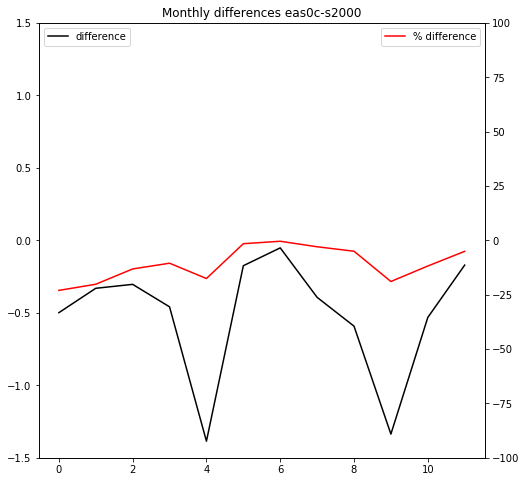

In [175]:
print((diffabs))
fig, ax1=plt.subplots()
ax1.plot(diffabs,label='difference',color='black')
plt.legend(loc=2)
ax2=ax1.twinx()
ax2.plot(diffratio,label='% difference',color='red')
ax1.set_title('Monthly differences eas0c-s2000')
plt.legend()
ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-100.,100.)
plt.show()

In [ ]:
avediff=np.mean(s1-s2,axis=0)
avediffratio=np.mean((s1-s2)/s1,axis=0)
print(np.shape(s1))
print(np.shape(avediff))
t1,p1 = ttest_ind(s2raw.PPT,s1raw.PPT)
lim1 = clps.stats_fdr(p1,0.1)
pp1 = np.ma.masked_greater(p1, lim1)
print('new min',lim1)

print(np.mean(s1_mth-s2_mth),np.nanmean(np.mean(s1-s2,axis=0)),np.mean(s1raw.PPT-s2raw.PPT))

(12, 89, 170)
(89, 170)
new min 0.04788499669530734
<xarray.DataArray 'PPT' ()>
array(-0.7148888944991195) -0.714888894499 <xarray.DataArray 'PPT' ()>
array(-0.7150105805559133)


In [36]:
#to prove that masked in ma.masekd_greater means remove.
# a=[1,2,3,4,5]
# b=[1,2,3,4,5]
# t1,p1=ttest_ind(a,b)
# print(t1,p1)
# pp1=np.ma.masked_greater(p1,0.1)
# print(pp1)

0.0 1.0
--


### Plot domain spatial differences

In [303]:
# Define plotting and significance functions
def ave_diff(var):
    s2_mth=s2raw[var]#.groupby('time.month').mean(axis=0)
    s1_mth=s1raw[var]#.groupby('time.month').mean(axis=0)
    pctDiff=(np.mean(s1_mth)-np.mean(s2_mth))/np.mean(s1_mth)*100
    return np.mean(s1_mth-s2_mth,axis=0),pctDiff
# s1_rainnc=s1raw.RAINNC.groupby('time.month').mean(axis=0)
# s2_rainnc=s2raw.RAINNC.groupby('time.month').mean(axis=0)
# avediff_rainnc=np.mean(s2_rainnc-s1_rainnc,axis=0)
# avediffratio_rainnc=np.mean((s2_rainnc-s1_rainnc)/s1_rainnc,axis=0)
def sigMask(s2,s1):
    t1,p1 = ttest_ind(s2,s1)
    lim1 = clps.stats_fdr(p1,0.05)
    pp1 = np.ma.masked_greater(p1, lim1)
    print('new lim ',lim1,np.shape(s2),np.shape(s1))
    return pp1

def sem_diff(data1,data2):
    return (calculate_sem(data1)**2+calculate_sem(data2)**2)**0.5

def calculate_sem(ppt_data):
    ti,lat,lon=np.shape(ppt_data)
    return sem(np.mean(np.reshape(ppt_data.resample('A',dim='time',how='mean').data,(-1,lat,lon)),axis=(1,2)),axis=0)

def plt_diff(var,title,ax):
    aveDiff,pctDiff=ave_diff(var)
    ax.pcolor(s1raw.lon,s1raw.lat,aveDiff,cmap='BrBG',vmin=-3,vmax=3)
    # ax.contour(s1raw.lon,s1raw.lat,geo02.HGT_M[0,5:-5,5:-5],levels=[50,100,200,400,800])
    ax.coastlines()
    ax.add_feature(cfeature.RIVERS)
    cmap = plt.get_cmap('BrBG')
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=-3, vmax=3))
    sm._A = []
    plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05) #fraction=0.25 for d01
    ax.pcolor(s1raw.lon, s1raw.lat, sigMask(s2raw[var],s1raw[var]), hatch='/', alpha=0.)
    titleLine=title+' \n Avg Diff= '+str('{:.4f}'.format(np.nanmean(aveDiff)))+'('+str('{:.4f}'.format(sem_diff(s1raw[var],s2raw[var])))+')'+'mm/day ='+str('{:.2f}'.format(float(pctDiff)))+'%'
    plt.title(titleLine)


new lim  0.020442828816920028 (5475, 89, 170) (5475, 89, 170)
new lim  0.0061764705882352946 (5475, 89, 170) (5475, 89, 170)
new lim  0.023169200264375415 (5475, 89, 170) (5475, 89, 170)


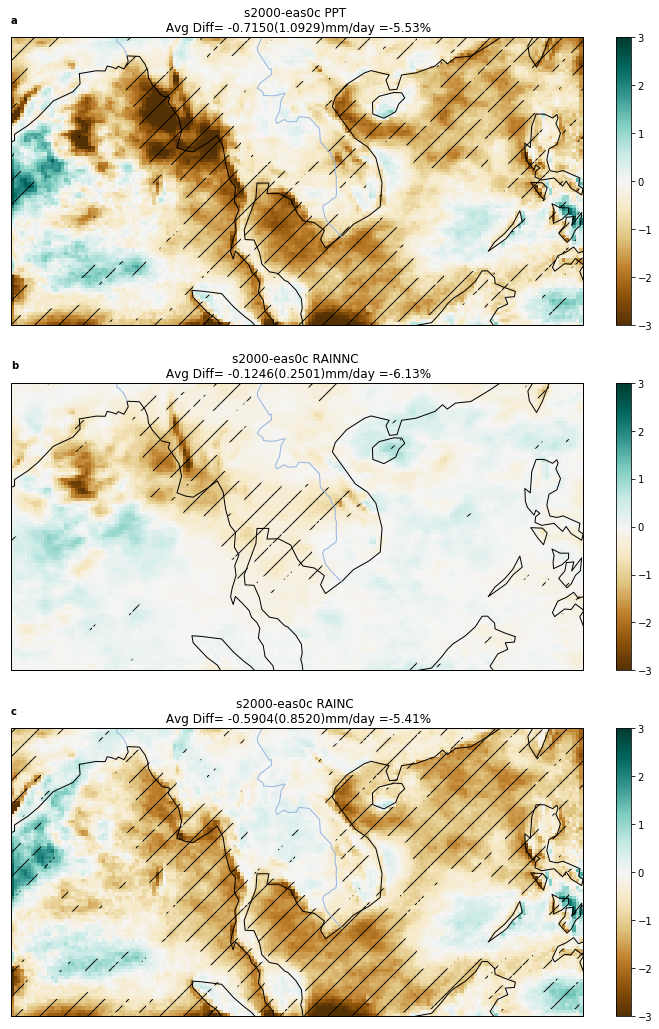

In [320]:
plt.rcParams["figure.figsize"] = 12,18#12,8,6
plt.figure(1)
ax1=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
title='s2000-eas0c PPT'
plt_diff('PPT',title,ax1)
ax1.text(0.0, 1.05, 'a', transform=ax1.transAxes, 
            size=10, weight='bold')

# plt.figure(2)
ax2=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINNC'
plt_diff('RAINNC',title,ax2)
ax2.text(0, 1.05, 'b', transform=ax2.transAxes, 
            size=10, weight='bold')

s1raw['RAINC']=s1raw.PPT-s1raw.RAINNC
s2raw['RAINC']=s2raw.PPT-s2raw.RAINNC
# plt.figure(3)
ax3=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINC'
plt_diff('RAINC',title,ax3)
ax3.text(0.0, 1.05, 'c', transform=ax3.transAxes, 
            size=10, weight='bold')

plt.show()

(180, 89)
(180, 89)
(12, 89)
(180, 89)
(180, 89)
(12, 89)
(180, 89)
(180, 89)
(12, 89)


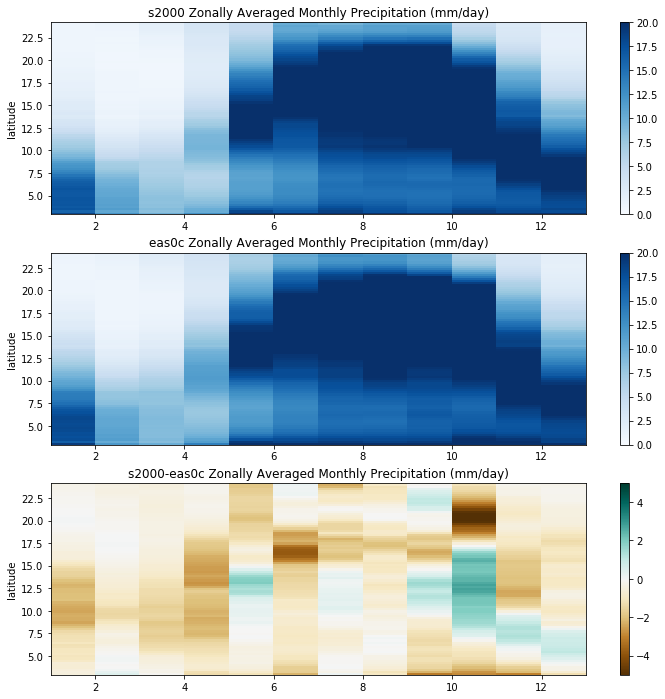

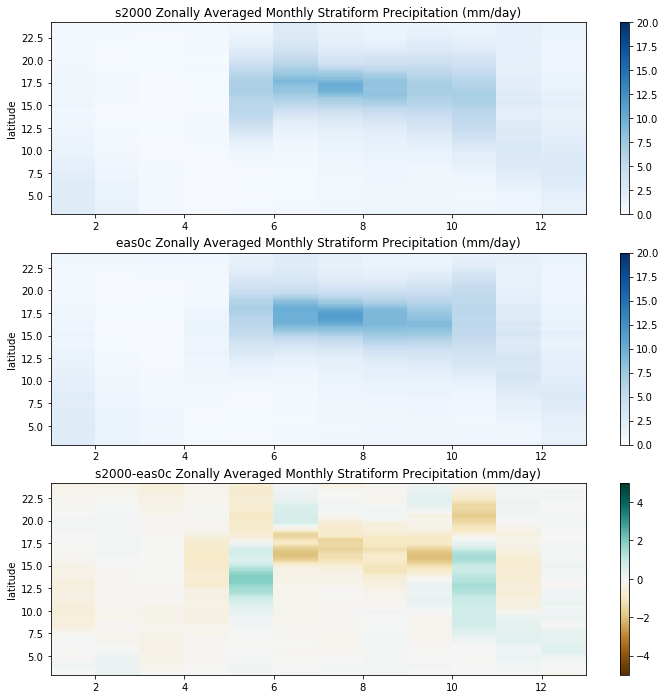

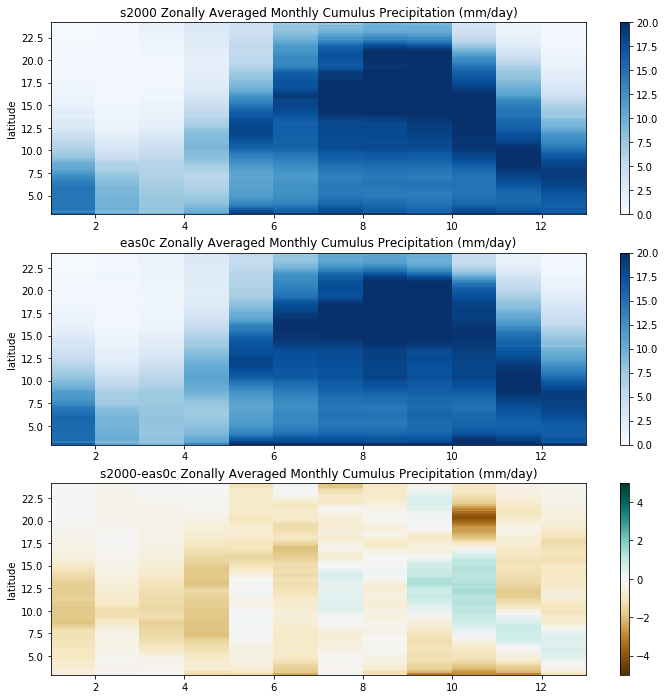

In [321]:
plt.rcParams["figure.figsize"] = 12,12
s1raw['RAINC']=s1raw.PPT-s1raw.RAINNC
s2raw['RAINC']=s2raw.PPT-s2raw.RAINNC
np.shape(s1raw.PPT)
lat_val=s1raw.lat
time_val=s1raw.time
time_val2=np.arange('2000','2015', dtype='datetime64[Y]')
time_val3=np.arange('2000','2015', dtype='datetime64[M]')
my_xticks=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15']
locator = matplotlib.dates.YearLocator()

lats_mth=np.mean(s1,axis=2)
print(np.shape(lats))
plt.figure(1)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s2,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1,axis=2)-np.mean(s2,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1_cl,axis=2)
print(np.shape(lats))
plt.figure(2)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Stratiform Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s2_cl,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Stratiform Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1_cl,axis=2)-np.mean(s2_cl,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Stratiform Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1-s1_cl,axis=2)
print(np.shape(lats))
plt.figure(3)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Cumulus Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s2-s2_cl,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Cumulus Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1-s1_cl,axis=2)-np.mean(s2-s2_cl,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),lat_val,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Cumulus Precipitation (mm/day)')
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

plt.show()

## Comparisons for qcloud

In [126]:
c1=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run3d_2000_d02.nc')
c2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run3d_eas0c_d02.nc')

<xarray.Dataset>
Dimensions:   (lat: 170, lon: 173, lvl: 29, time: 1825)
Coordinates:
  * time      (time) datetime64[ns] 2050-01-01 2050-01-02 2050-01-03 ...
  * lvl       (lvl) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat       (lat) float32 6.73963 6.82241 6.90515 6.98789 7.07063 7.15334 ...
  * lon       (lon) float32 95.7448 95.8281 95.9115 95.9948 96.0782 96.1615 ...
Data variables:
    LANDMASK  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    z         (time, lvl, lat, lon) float64 29.76 29.75 29.76 29.77 29.76 ...
    QCLOUD    (time, lvl, lat, lon) float64 6.139e-11 1.245e-09 0.0 0.0 ...
    ALT       (time, lvl, lat, lon) float64 0.8703 0.8703 0.8705 0.8706 ...
Attributes:
    history:                    Mon Oct 16 19:13:47 2017: ncea wrfpost_run_20...
    NCO:                        "4.6.1"
    nco_openmp_thread_number:   1
    history_of_appended_files:  Sat Oct 14 05:28:48 2017: Appended file /home...
28
(1825, 29, 170, 173)


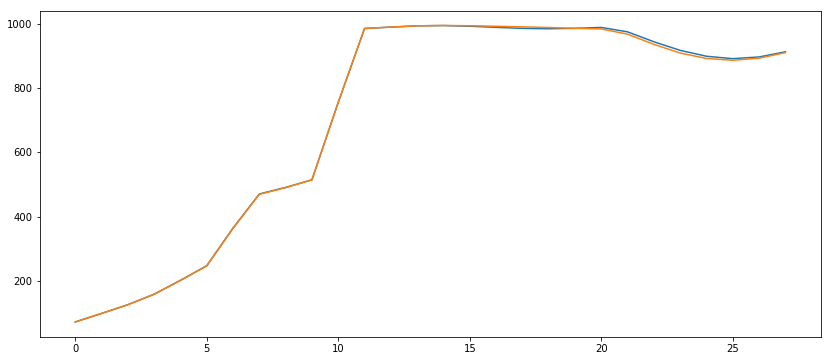

In [130]:
plt.rcParams["figure.figsize"] = 14,6
print(c1)
# plt.plot(c1.z[80,:,80,80])

inter=[]
inter2=[]
for i in range(1,29):
    inter.append(c1.z[80,i,80,80]-c1.z[80,i-1,80,80])
for i in range(1,29):
    inter2.append(c2.z[80,i,80,80]-c2.z[80,i-1,80,80])
plt.plot(inter)
plt.plot(inter2)

print(len(inter))
print(np.shape(c1.z))
plt.show()

In [4]:
#calculate cloud mass per m^2 this assumes z is not cumulative
s1cloud=c1.QCLOUD/c1.ALT*c1.z
s2cloud=c2.QCLOUD/c2.ALT*c1.z

In [5]:
aa=np.sum(s1cloud.data)
bb=np.sum(s2cloud.data)
print('{:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(aa,bb,bb-aa,(bb-aa)/aa*100))


13876567.7269, 14585170.6110, 708602.8841, 5.1065%


In [6]:
s1cloudcut=s1cloud.sel(time=slice('2052-01-01', '2055-01-01'))
s2cloudcut=s2cloud.sel(time=slice('2052-01-01', '2055-01-01'))
print(np.shape(s1cloud))
s1cloudmtha=s1cloudcut.resample('1M',dim='time',how='mean')
s2cloudmtha=s2cloudcut.resample('1M',dim='time',how='mean')
print(np.shape(s2cloudmtha))
s1cloudmth=s1cloudmtha.groupby('time.month').mean(axis=0)
s2cloudmth=s2cloudmtha.groupby('time.month').mean(axis=0)
# s1cloudmth.to_netcdf('/home/likkhian/dhobyghaut/cesm_output_convert/analysis/downscale_results/qcloud_mth_s2000.nc')
# s2cloudmth.to_netcdf('/home/likkhian/dhobyghaut/cesm_output_convert/analysis/downscale_results/qcloud_mth_eas0c.nc')
# s1cloudmth=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/qcloud_mth_s2000.nc')
# s2cloudmth=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/qcloud_mth_eas0c.nc')
print(np.shape(s1cloudmth))
# print(np.shape(s1cloudmth.__xarray_dataarray_variable__))

(1825, 29, 170, 173)
(36, 29, 170, 173)
(12, 29, 170, 173)


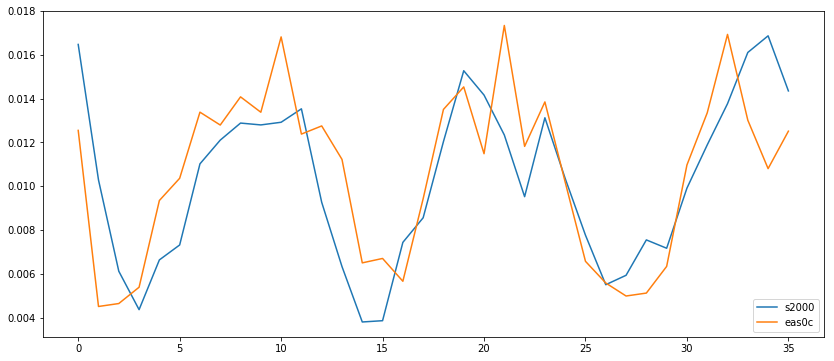

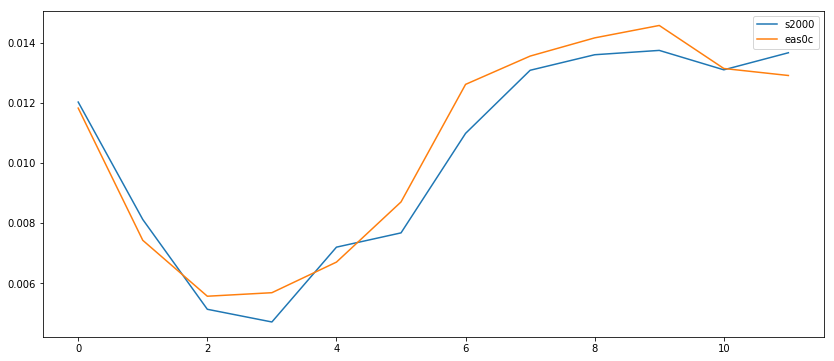

In [7]:
plt.figure(1)
plt.plot(np.mean(s1cloudmtha,axis=(1,2,3)),label='s2000')
plt.plot(np.mean(s2cloudmtha,axis=(1,2,3)),label='eas0c')
plt.legend()

plt.figure(2)
plt.plot(np.mean(s1cloudmth,axis=(1,2,3)),label='s2000')
plt.plot(np.mean(s2cloudmth,axis=(1,2,3)),label='eas0c')
plt.legend()

plt.show()

In [8]:
print('month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000')
for tt in range(0,12):
    a=np.sum(s1cloudmth[tt,:,:,:].data)#.__xarray_dataarray_variable__[tt,:,:,:].data)
    b=np.sum(s2cloudmth[tt,:,:,:].data)#.__xarray_dataarray_variable__[tt,:,:,:].data)
    print('{}, {:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(tt+1,a,b,b-a,(b-a)/a*100))
print('All, {:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(np.sum(s1cloudmth.data),np.sum(s2cloudmth.data),np.sum(s2cloudmth.data)-np.sum(s1cloudmth.data),(np.sum(s2cloudmth.data)-np.sum(s1cloudmth.data))/np.sum(s1cloudmth.data)*100))

month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000
1, 10263.8396, 10092.1120, -171.7276, -1.6731%
2, 6932.8946, 6342.5810, -590.3136, -8.5147%
3, 4385.7905, 4756.0239, 370.2333, 8.4417%
4, 4025.7188, 4856.2369, 830.5181, 20.6303%
5, 6148.2023, 5724.0534, -424.1489, -6.8987%
6, 6553.1076, 7430.5333, 877.4257, 13.3895%
7, 9375.8804, 10765.6644, 1389.7840, 14.8230%
8, 11165.5405, 11567.9899, 402.4493, 3.6044%
9, 11606.3236, 12084.6815, 478.3579, 4.1215%
10, 11729.1931, 12436.5651, 707.3719, 6.0309%
11, 11178.4660, 11215.9444, 37.4784, 0.3353%
12, 11662.5519, 11017.3541, -645.1979, -5.5322%
All, 105027.5089, 108289.7397, 3262.2308, 3.1061%


### from 3 yrs of data
month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000 <br>
1, 10263.8396, 10092.1120, -171.7276, -1.6731% <br>
2, 6932.8946, 6342.5810, -590.3136, -8.5147% <br>
3, 4385.7905, 4756.0239, 370.2333, 8.4417% <br>
4, 4025.7188, 4856.2369, 830.5181, 20.6303% <br>
5, 6148.2023, 5724.0534, -424.1489, -6.8987% <br>
6, 6553.1076, 7430.5333, 877.4257, 13.3895% <br>
7, 9375.8804, 10765.6644, 1389.7840, 14.8230% <br>
8, 11165.5405, 11567.9899, 402.4493, 3.6044% <br>
9, 11606.3236, 12084.6815, 478.3579, 4.1215% <br>
10, 11729.1931, 12436.5651, 707.3719, 6.0309% <br>
11, 11178.4660, 11215.9444, 37.4784, 0.3353% <br>
12, 11662.5519, 11017.3541, -645.1979, -5.5322% <br>

### from 5 yrs of data
month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000 <br>
1, 8182.4760, 8530.1588, 347.6828, 4.2491% <br>
2, 5534.7462, 5541.9107, 7.1645, 0.1294% <br>
3, 3665.7372, 4348.2797, 682.5424, 18.6195% <br>
4, 3277.8825, 3845.5130, 567.6306, 17.3170% <br>
5, 5098.9709, 5393.8096, 294.8387, 5.7823% <br>
6, 5655.6789, 6867.5313, 1211.8524, 21.4272% <br>
7, 8304.8219, 9240.5539, 935.7320, 11.2673% <br>
8, 10357.6125, 11007.8795, 650.2670, 6.2782% <br>
9, 10222.5415, 11112.8884, 890.3469, 8.7096% <br>
10, 10379.1819, 10770.6256, 391.4436, 3.7714% <br>
11, 9573.8657, 9452.8191, -121.0466, -1.2643% <br>
12, 10753.0003, 9574.5381, -1178.4621, -10.9594% <br>

### from the old QCLOUD/ALT method.
month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000 <br>
1, 2.9401, 4.0482, 1.1081, 37.6895% <br>
2, 2.0836, 2.7201, 0.6366, 30.5525%<br>
3, 1.5781, 2.7416, 1.1635, 73.7331%<br>
4, 0.7897, 1.2373, 0.4477, 56.6905%<br>
5, 0.7766, 1.4627, 0.6861, 88.3409%<br>
6, 1.5147, 2.2099, 0.6952, 45.8989%<br>
7, 3.3710, 2.8347, -0.5363, -15.9086%<br>
8, 4.9462, 4.5077, -0.4384, -8.8644%<br>
9, 4.2341, 4.1415, -0.0927, -2.1885%<br>
10, 3.0768, 2.2144, -0.8624, -28.0300%<br>
11, 2.7405, 2.1833, -0.5573, -20.3337%<br>
12, 3.7496, 3.2070, -0.5426, -14.4705%<br>

In [59]:
landmask=s1a.LANDMASK[0,:,:]
print('month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000')
for tt in range(0,12):
    a=np.sum(np.sum(s1cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=0)*landmask.data)
    b=np.sum(np.sum(s2cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=0)*landmask.data)
#     print((tt+1,a,b,b-a,(b-a)/a))
    print('{}, {:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(tt+1,a,b,b-a,(b-a)/a*100))

month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000
1, 1.6170, 2.1669, 0.5499, 34.0079%
2, 1.0568, 1.4802, 0.4234, 40.0581%
3, 0.8170, 1.5677, 0.7507, 91.8822%
4, 0.4386, 0.7806, 0.3420, 77.9870%
5, 0.5207, 1.1131, 0.5924, 113.7782%
6, 1.1405, 1.7020, 0.5614, 49.2249%
7, 2.5283, 2.2216, -0.3067, -12.1295%
8, 3.8052, 3.5280, -0.2773, -7.2868%
9, 3.1441, 3.1859, 0.0418, 1.3291%
10, 2.0649, 1.4373, -0.6276, -30.3937%
11, 1.5827, 1.3129, -0.2698, -17.0448%
12, 1.9573, 1.6765, -0.2808, -14.3484%


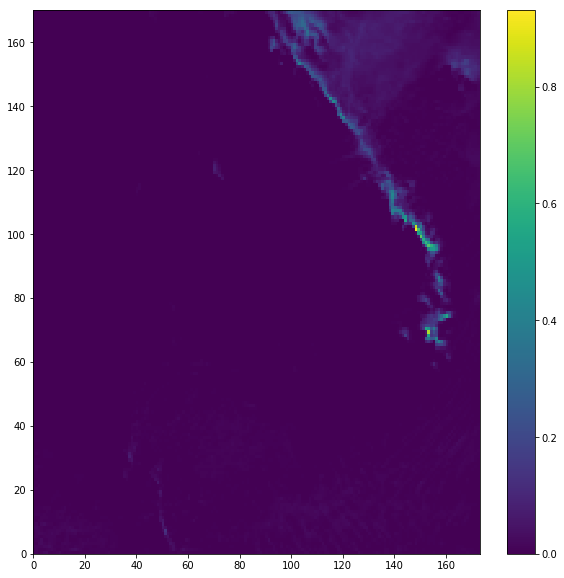

In [95]:
# print(np.shape(np.sum(s1cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=2)))
# print((np.sum(s1cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=2)*landmask.data))
# print((np.sum(s1cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=2)))
# print(landmask.data)
plt.pcolor(s1cloud[tt,5,:,:].data)
plt.colorbar()
plt.show()

## trmm monthly ppt and wind directions

In [11]:
trmm=xr.open_dataset('../ppt_data/trmm_monthly.nc',decode_times=False)
print(trmm)
ti,nlat,nlon=trmm.PPT.shape
print(trmm.PPT.shape)
trmmmth=trmm.PPT[:228,:,:].data.reshape((-1,12,nlat,nlon))

<xarray.Dataset>
Dimensions:  (lat: 400, lon: 1440, time: 234)
Coordinates:
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) float32 -49.875 -49.625 -49.375 -49.125 -48.875 -48.625 ...
  * lon      (lon) float32 -179.875 -179.625 -179.375 -179.125 -178.875 ...
Data variables:
    PPT      (time, lat, lon) float64 0.5119 0.5777 0.4229 0.3213 0.419 ...
Attributes:
    title:    monthly averaged precipitation combined microwave-IR with gauge...
(234, 400, 1440)


(19, 12, 400, 1440)


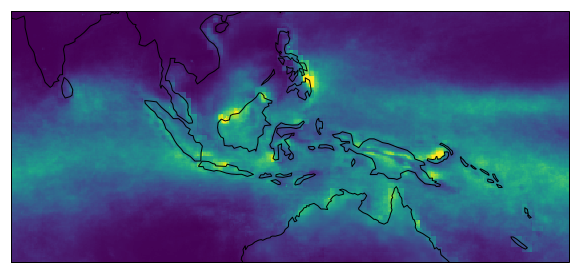

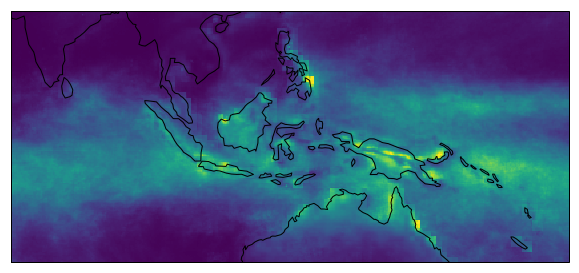

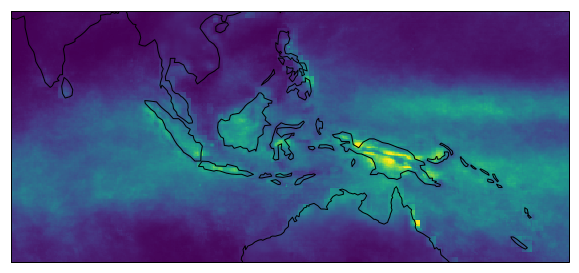

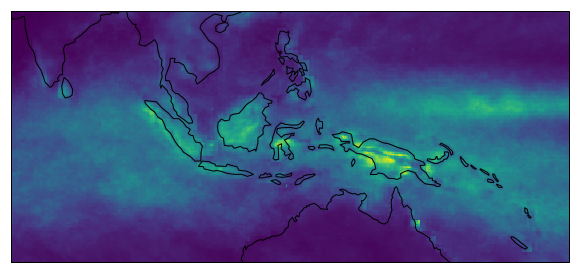

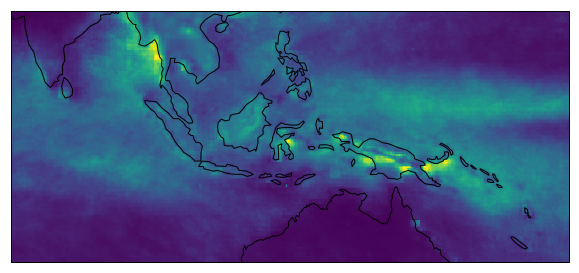

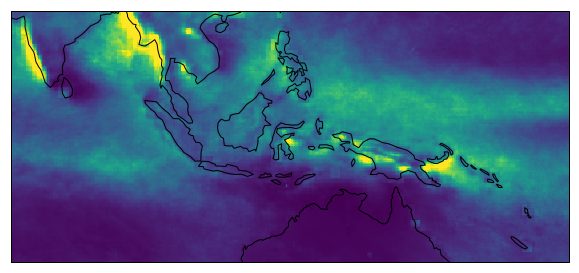

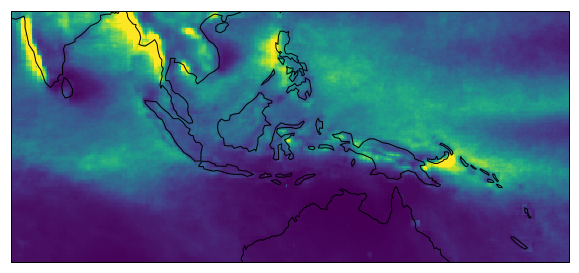

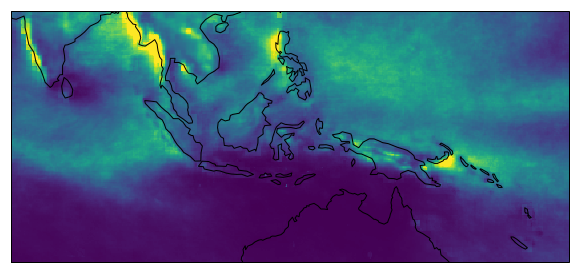

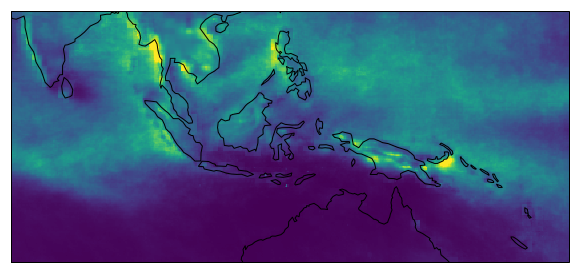

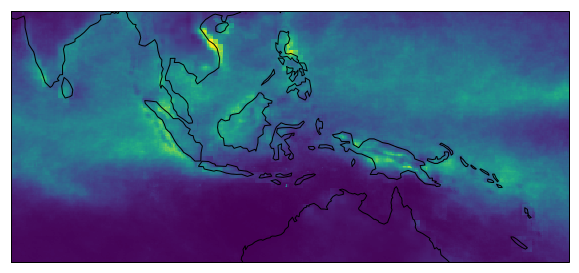

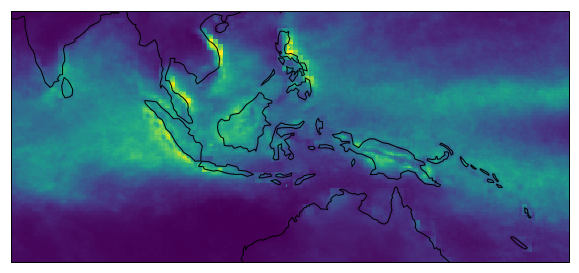

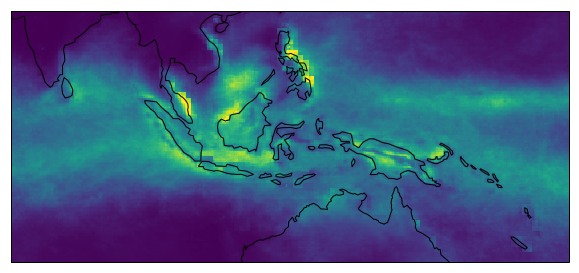

In [12]:
print(trmmmth.shape)
trmmyr=np.mean(trmmmth,axis=0)
for tt in range (0,12):
    plt.figure(tt)
    ax1=plt.subplot(projection=ccrs.PlateCarree())
    ax1.pcolor(trmm.lon[1000:-20], trmm.lat[100:-110],trmmyr[tt,100:-110,1000:-20],vmin=0,vmax=20)
    ax1.coastlines()
plt.show()

## Raw output exploration

In [2]:
out1=xr.open_dataset('../cesm_output_convert/analysis/wrfout_d01_0054-08-01_03:00:00')
print(out1.CLDFRA)

<xarray.DataArray 'CLDFRA' (Time: 1, bottom_top: 29, south_north: 99, west_east: 180)>
[516780 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 1.67043 1.67043 1.67043 ...
    XLONG    (Time, south_north, west_east) float32 80.6577 80.9078 81.1578 ...
    XTIME    (Time) object   54-07-31 03:00:00
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  CLOUD FRACTION
    units:        
    stagger:      


/home/likkhian/anaconda3/envs/python3env/lib/python3.6/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/likkhian/anaconda3/envs/python3env/lib/python3.6/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [14]:
raleigh=out1.CLDFRA[0,:,5:-5,5:-5]
print(raleigh.shape)
plt.figure(1)
maxx=np.max(np.mean(raleigh,axis=0))
minn=np.min(np.mean(raleigh,axis=0))
ax1=plt.subplot(projection=ccrs.PlateCarree())
ax1.contourf(s1.lon, s1.lat,np.mean(raleigh,axis=0))
ax1.coastlines()
sm = plt.cm.ScalarMappable(cmap='viridis',norm=plt.Normalize(minn,maxx))
sm._A = []
plt.colorbar(sm,ax=ax1,shrink=0.4)
plt.show()

(29, 89, 170)


AttributeError: 'numpy.ndarray' object has no attribute 'lon'

In [ ]:
ss=np.zeros([2,2])
print(ss)
print(ss+1)

In [81]:
tt=0
str('{} \n PPT Bias: {:.2f}({:.2f}), {:.2f}% \n U/V bias: U:{:.2f}, V:{:.2f}'.format(quarters[tt+1],np.nanmean(pptdiff[tt,:,:]),\
            (((sem(np.mean(s1_qtr_shaped,axis=(2,3))))**2+(sem(np.mean(s2_qtr_shaped,axis=(2,3))))**2)**0.5)[tt], (np.nanmean(pptdiff[tt,:,:])/np.nanmean(s1_qtr[tt,:,:])*100), \
            float(np.mean(udiff[tt,:,:])),float(np.mean(vdiff[tt,:,:])) ))

'DJF \n PPT Bias: 0.90(1.28), 11.65% \n U/V bias: U:-0.83, V:0.06'

In [91]:
a=sem(np.mean(s1_qtr_shaped,axis=(2,3)))
b=sem(np.mean(s2_qtr_shaped,axis=(2,3)))
print(a,b)
print(a**2,b**2)
print((a**2+b**2)**0.5)

[ 0.92661825  1.00219798  0.90265854  0.51957046] [ 0.8812646   0.96596807  1.00403459  0.66036398]
[ 0.85862138  1.00440079  0.81479244  0.26995346] [ 0.7766273   0.93309432  1.00808545  0.43608059]
[ 1.27876842  1.39193933  1.35013996  0.84025832]
